In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
import torch
import torch.nn as nn
from pytorch_forecasting.metrics import SMAPE,RMSE,MAPE
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
from torch.optim import Adam

/home/sjlee/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from torch.nn.functional import softmax

In [4]:
use_col = ['volumn']
data = pd.read_csv('../../traffic/data/3.csv',usecols=use_col)
data.rename({'volumn':'value'},axis=1,inplace=True)
data['value'] = data['value'] * 8 / 1000000
data

,value
0,0.220168
1,0.221584
2,0.205680
3,0.185184
4,0.173464
...,...
38875,0.166704
38876,0.172936
38877,0.172976
38878,0.169264


<AxesSubplot: >

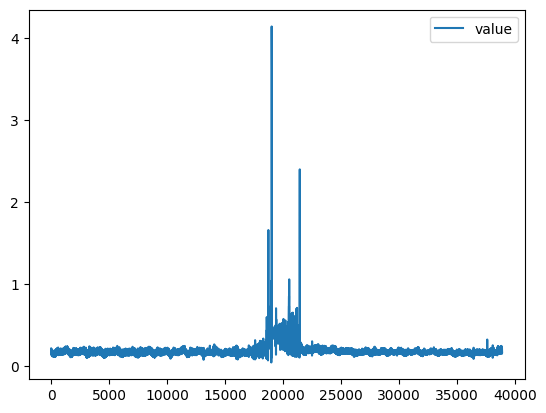

In [5]:
data.plot()

In [6]:
import configparser
import os
config = configparser.ConfigParser()
config['online-learning-DLinear']= {
    'seq_len':1440,
    'pred_len':1,
    'individual':bool(False),
    'enc_in':1
}
with open('online-learning-DLinear','w') as f:
    config.write(f)
    
config.read(os.getcwd()+os.sep+'online-learning-DLinear')

['/hdd_1/sjlee/Paper_Project/SelfMadeModelExperiment4/online-learning-DLinear']

In [7]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        
        x = x.permute(0, 2, 1)
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size) // 2, 1) #720
        
        end = x[:, -1:, :].repeat(1, (self.kernel_size) // 2, 1) #720
        
        x = torch.cat([front, x, end], dim=1)
       
        x = self.avg(x.permute(0,2,1))
        
        
        return x

class series_decomp(nn.Module):
    "statsmodels.tsa의 seasonal_decompose와 역할이 똑같다"
    def __init__(self,kernel_size,stride):
        super(series_decomp,self).__init__()
        self.moving_avg = moving_avg(kernel_size=kernel_size,stride=stride)
    
    def forward(self,x):
        moving_mean = self.moving_avg(x) #output은 (batch,sequence_length,input_size)
        
        moving_mean = moving_mean.permute(0,2,1)
        
        x = x.permute(0,2,1)
        
        res = torch.cat([x[:,:720,:] - moving_mean[:,0:1,:],x[:,720:,:]-moving_mean[:,1:2,:]],dim=1)
        
        # Classical ma중에서 additive model
        return res,moving_mean

In [8]:
A=FloatTensor([[[1,2,3]],[[4,5,6]]])
B=FloatTensor([[[1,2,3]],[[4,5,6]]])
C=(A*B).sum(dim=2).view(-1,1,1)
D=FloatTensor([[[1,2,3]],[[4,5,6]]])
E=FloatTensor([[[1,2,3]],[[1,2,3]]])
F=(-1*(torch.abs(D-E).sum(dim=2))).view(-1,1,1)

print(F*E)
print(D[:,:,0:2])
#list_f = [C,F]
# for i in list_f:
#     print(i)
#torch.cat([C,F],dim=2)

torch.cat([FloatTensor(),C],dim=2)

tensor([[[ -0.,  -0.,  -0.]],

        [[ -9., -18., -27.]]])
tensor([[[1., 2.]],

        [[4., 5.]]])


tensor([[[14.]],

        [[77.]]])

In [9]:
class Model(nn.Module):
    "Decomposition - Linear"
    def __init__(self,configs): # 내가 만든 configure module file
        super(Model,self).__init__()
        self.device = torch.device('cuda:0')
        self.seq_len = int(configs['online-learning-DLinear']['seq_len']) # configure의 sequence length
        self.pred_len = int(configs['online-learning-DLinear']['pred_len']) # configure의 prediction length1
        self.SMALLKERNEL = 60
        
        # Decomposition Kernel Size
        kernel_size = 1440
        self.stride = 1440
        self.decomposition = series_decomp(kernel_size,self.stride)
        # residual과 moving_average 값을 받기 위한 decomposition model
        self.individual = configs['online-learning-DLinear']['individual'] # 1) 특성각각에 대해 별도의 layer를 둘것이냐의여부 이고
        self.channels = int(configs['online-learning-DLinear']['enc_in']) # 2) 이때 특성의개수
        

        self.Linear_Seasonal = nn.Linear(2*self.SMALLKERNEL,self.pred_len)
        self.Linear_Trend = nn.Linear(2,self.pred_len)
        self.Linear_plus = nn.Linear(2,1)
        
        
#         self.Kernel_Linear = nn.ModuleList()
#         for i in range(seasonal_init.size(-1)//SMALLKERNEL):
#             self.Kernel_Linear.append(nn.Linear())
            
    def forward(self,x):
        x=x.permute(0,2,1)
        div_factor = x[:,-1,:].view(-1,1,1)
        x = (x-div_factor).permute(0,2,1)
        # x의 size는 [Batch, Input_length, Channel]
        seasonal_init,trend_init = self.decomposition(x) # res = seasonality 를 moving_mean은 trend를 의미함
        seasonal_init,trend_init = seasonal_init.permute(0,2,1).to(self.device), trend_init.permute(0,2,1).to(self.device)
        
        
 
        STANDARD = seasonal_init[:,:,-self.SMALLKERNEL:]
        Score_List = []
        Vector_List = []
    
        
        for i in range(self.SMALLKERNEL,seasonal_init.size(-1)-self.SMALLKERNEL+1):
            Comparison_Vector = seasonal_init[:,:,-i-self.SMALLKERNEL:-i]
            Vector_List.append(Comparison_Vector)
            score = (-1*(torch.abs(STANDARD-Comparison_Vector).sum(dim=2))).view(-1,1,1) 
            # 거리를 구한후에 -를 붙여준다
            # 이를 통해 그래프의 모양이 많이 차이나는 것은 가중치를 덜 받게 된다
            Score_List.append(score)
            
        score_tensor = FloatTensor().to(self.device)
        value_tensor = torch.zeros(size=(seasonal_init.size(0),1,self.SMALLKERNEL)).to(self.device)
        
        for i in Score_List:
            score_tensor = torch.cat([score_tensor,i],dim=2)

        Prob_Score = softmax(score_tensor,dim=2)
        
        
#         print(Prob_Score[:,:,0].view(-1,1,1).size())
#         print(Vector_List[0].size())
#         print(value_tensor.size())
        for i in range(Prob_Score.size(2)):
            value_tensor=value_tensor+((Prob_Score[:,:,i].view(-1,1,1))*Vector_List[i])
            # 빈 Tensor와는 덧셈과 같은 텐서연산이 불가능하다
            
        seasonal_input = torch.cat([value_tensor,STANDARD],dim=2)
        seasonal_output = self.Linear_Seasonal(seasonal_input)    
        trend_output = self.Linear_Trend(trend_init)
        new_input = torch.cat([seasonal_output,trend_output],dim=2)
        
        x = self.Linear_plus(new_input)
        x = x+div_factor
        return x.permute(0,2,1).to(self.device) # batch size, output_length(not sequence_length Layer를 돌면서 크기가 바뀜), channel(feature_size)로 변경해서 return

In [10]:
def seq_data(x,sequence_length,pred_len):
    seq_list = []
    target_list = []
    device = torch.device("cuda:0")
    if (type(x)==list)|(type(x)==np.ndarray):
        for i in range(len(x)-sequence_length):
            seq_list.append(x[i:i+sequence_length].values)
            target_list.append(x[i+sequence_length])
    
    if (type(x) == pd.Series)|(type(x) == pd.DataFrame):
        for i in range(len(x)-sequence_length):
            seq_list.append(x.iloc[i:i+sequence_length].values)
            target_list.append(x.iloc[i+sequence_length])

#             if i == 0:
#                  print(x.iloc[i:i+sequence_length].values)
#                  print(y[i+sequence_length:i+sequence_length+pred_len].values)
            #print(x[i+sequence_length:i+sequence_length+pred_len].values.shape)
    else:
        print('error')

    return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)

In [11]:
sequence_length = 1440
pred_len = 1
split= 10080 #7일(Test Set)
x_data = data.iloc[:-split]
x_seq,target = seq_data(x=x_data,sequence_length=sequence_length,pred_len=pred_len)

/tmp/ipykernel_595340/197408478.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  return FloatTensor(seq_list).view(-1,1,sequence_length).to(device),FloatTensor(target_list).unsqueeze(1).view(-1,1,pred_len).to(device)


In [12]:
torch.manual_seed(42)

In [13]:
import torch.optim as optim

device = torch.device('cuda:0')
batch_size = 32
num_epochs = 100
train_dataset = TensorDataset(x_seq,target)
training = DataLoader(train_dataset,batch_size=batch_size)
model = Model(config).to(device)
optimizer = Adam(model.parameters(),1e-4)
criterion = SMAPE()
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.99 ** epoch,verbose = True)
                                       # epoch마다 learning rate에 곱해지는 값이 제곱수로 늘어남

Adjusting learning rate of group 0 to 1.0000e-04.


In [14]:
torch.manual_seed(42)

In [15]:
out_list = []
loss_list = []
time_list1 = []
n = len(training)
for i in range(num_epochs):
    running_loss = 0.0
    Start = time.time()
    for seq,tg in training:

        out = model(seq)
        
        loss = criterion(out,tg)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()   
        
    End = time.time()
    
    time_list1.append(End-Start)
    
    scheduler.step() #schedular update
    
    loss_list.append(running_loss/n)
    print('smape',running_loss/n*100,'%')        

Adjusting learning rate of group 0 to 9.9000e-05.
smape 12.48863252631405 %
Adjusting learning rate of group 0 to 9.8010e-05.
smape 10.023718820939287 %
Adjusting learning rate of group 0 to 9.7030e-05.
smape 9.794706599405636 %
Adjusting learning rate of group 0 to 9.6060e-05.
smape 9.686104463119257 %
Adjusting learning rate of group 0 to 9.5099e-05.
smape 9.614825040450569 %
Adjusting learning rate of group 0 to 9.4148e-05.
smape 9.563761859783652 %
Adjusting learning rate of group 0 to 9.3207e-05.
smape 9.525930118578218 %
Adjusting learning rate of group 0 to 9.2274e-05.
smape 9.494948314818723 %
Adjusting learning rate of group 0 to 9.1352e-05.
smape 9.46933654273114 %
Adjusting learning rate of group 0 to 9.0438e-05.
smape 9.447395980183842 %
Adjusting learning rate of group 0 to 8.9534e-05.
smape 9.426047300037585 %
Adjusting learning rate of group 0 to 8.8638e-05.
smape 9.404873799598008 %
Adjusting learning rate of group 0 to 8.7752e-05.
smape 9.386473153853975 %
Adjusting le

In [16]:
device = torch.device('cuda:0')
X = data.iloc[:-split]
target = data.iloc[-split:]
pred_list = []
time_list = []

for idx in range(split):
    running_loss = 0.0
    start = time.time()
    model.train()
    for epochs in range(num_epochs):
        if idx == 0: 
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1:-1].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)

            tg = FloatTensor(X.iloc[-1]).view(1,1,1).to(device)
           
        elif idx == 1:
            new_train = torch.FloatTensor(
                [X.iloc[-sequence_length-1+idx:].values] # 현재 알고 있는 마지막 정답에서 하나 이전 값 까지가 Training Data
            ).view(1,1,-1).to(device)
            
            tg = FloatTensor(target.iloc[0]).view(1,1,1).to(device)
        else:        
            if idx <= sequence_length:# idx가 1보다는 크고 sequence_length보단 작거나 같은경우
                new_train = torch.FloatTensor(
                    [pd.concat([X.iloc[-sequence_length+idx-1:],target.iloc[0:idx-1]],axis=0,ignore_index=True).values]
                    ).view(1,1,-1).to(device)

                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

            elif idx > sequence_length:
                new_train = torch.FloatTensor(
                    [target.iloc[idx-sequence_length-1:idx-1].values]
                    ).view(1,1,sequence_length).to(device)
                
                tg = FloatTensor(target.iloc[idx-1]).view(1,1,1).to(device)

        out = model(new_train) # 예측완료
        
        loss = criterion(out,tg)# 예측값과 타겟값의 비교
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step() # optimizer 최적화
        
        running_loss = running_loss + loss.item()
        
#         if epochs == 0:
#             prev_loss = loss
            
#         elif loss < prev_loss:
#             prev_loss=loss
#             torch.save(model,PATH+'/best_model.pt') #모델의 갱신
            
#         running_loss = running_loss + loss.item()
    
#     real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    
#     model = torch.load(PATH+'/best_model.pt')

    real_input = torch.cat([new_train[:,:,1:],tg],dim=2)
    with torch.no_grad():
        model.eval()
        real_out = model(real_input)
    model.train()         
    print('SMAPE',(running_loss/100)*100,'%')
    end = time.time()
    pred_list.append(real_out.cpu().view(1).item())
    time_list.append(end-start)


SMAPE 0.027046665138414028 %
SMAPE 15.574741549789906 %
SMAPE 0.046054192746169065 %
SMAPE 1.7070941517449683 %
SMAPE 0.08227406921326974 %
SMAPE 0.17520113109048907 %
SMAPE 5.328802762553096 %
SMAPE 2.2289489165450505 %
SMAPE 0.436782850435975 %
SMAPE 1.227638366901374 %
SMAPE 0.1612552915376 %
SMAPE 10.893308348953724 %
SMAPE 0.23388760624300176 %
SMAPE 3.0811696939053945 %
SMAPE 6.974357340484858 %
SMAPE 5.573759529739618 %
SMAPE 7.829957459121943 %
SMAPE 3.8891067945369286 %
SMAPE 2.2100095118557874 %
SMAPE 1.1541450659055954 %
SMAPE 7.023969318717718 %
SMAPE 12.59739615023136 %
SMAPE 0.16963013374220282 %
SMAPE 1.466085028652742 %
SMAPE 0.21222646334490494 %
SMAPE 8.000317107886076 %
SMAPE 7.338745176792144 %
SMAPE 0.5167952071128639 %
SMAPE 0.587711783406121 %
SMAPE 0.17889543897217663 %
SMAPE 0.9046570276077547 %
SMAPE 14.853336602449419 %
SMAPE 2.435090351718827 %
SMAPE 0.18803437815461166 %
SMAPE 0.08835725726157762 %
SMAPE 3.544804694596678 %
SMAPE 7.791633956134319 %
SMAPE 2

SMAPE 6.7150483429431915 %
SMAPE 0.555319408283367 %
SMAPE 2.6843150878921733 %
SMAPE 0.23778372398123795 %
SMAPE 0.7473864972625961 %
SMAPE 0.31696224631195946 %
SMAPE 0.26586716491738116 %
SMAPE 0.09988433266971697 %
SMAPE 4.560724517796189 %
SMAPE 23.094301640987396 %
SMAPE 0.11634025706260331 %
SMAPE 0.32300200257304823 %
SMAPE 1.7486071854564216 %
SMAPE 0.12013940153047997 %
SMAPE 0.17665878415505176 %
SMAPE 1.718917881764355 %
SMAPE 0.04759384082649376 %
SMAPE 0.25312085209668567 %
SMAPE 1.5624324697018892 %
SMAPE 0.05288242423551992 %
SMAPE 3.9630263516155533 %
SMAPE 0.5006366170464389 %
SMAPE 1.214379336572165 %
SMAPE 7.681197285652161 %
SMAPE 0.1948709386133487 %
SMAPE 0.5640806265386118 %
SMAPE 10.413996927440166 %
SMAPE 5.313774990383536 %
SMAPE 2.8743475359442527 %
SMAPE 0.5896946186903733 %
SMAPE 2.266265749349259 %
SMAPE 0.5344969272625804 %
SMAPE 0.42612292344617225 %
SMAPE 2.445525220275158 %
SMAPE 0.06646718606009472 %
SMAPE 0.22242522851546198 %
SMAPE 0.73780227146608

SMAPE 0.26564408539957185 %
SMAPE 0.17850406490595105 %
SMAPE 2.2915267615462653 %
SMAPE 3.421141808241373 %
SMAPE 0.1864969856674179 %
SMAPE 0.6416765499179746 %
SMAPE 0.2745257217870858 %
SMAPE 7.69890858232975 %
SMAPE 1.9750240383509663 %
SMAPE 2.072643870698812 %
SMAPE 2.9299410515959607 %
SMAPE 1.45046859501781 %
SMAPE 0.07616240396356488 %
SMAPE 0.4617796660145359 %
SMAPE 0.014061915172760564 %
SMAPE 0.4026883553215157 %
SMAPE 1.562606565799797 %
SMAPE 0.20740197001669006 %
SMAPE 1.6974397521771607 %
SMAPE 2.0036244082439225 %
SMAPE 0.6893743417858786 %
SMAPE 7.545781221240759 %
SMAPE 3.515941869467497 %
SMAPE 4.970923277316615 %
SMAPE 0.03461421158027633 %
SMAPE 1.6061591520847285 %
SMAPE 0.4117525522742653 %
SMAPE 1.12204970665789 %
SMAPE 0.7858180000916947 %
SMAPE 2.9882140461631934 %
SMAPE 3.0733959657809464 %
SMAPE 0.46289486231944466 %
SMAPE 3.4305935450829566 %
SMAPE 2.4927652194164693 %
SMAPE 0.9887500803597505 %
SMAPE 0.14237093040588888 %
SMAPE 0.3174928011931115 %
SMAP

SMAPE 0.12502874697440802 %
SMAPE 0.33892176384506456 %
SMAPE 1.2049847795260575 %
SMAPE 1.7909505181851273 %
SMAPE 3.1906316175636675 %
SMAPE 0.06457027776878022 %
SMAPE 0.3822715936003078 %
SMAPE 0.31989745170756123 %
SMAPE 1.5526193100085948 %
SMAPE 0.38729509988672817 %
SMAPE 0.11130859674688054 %
SMAPE 0.050567442082410714 %
SMAPE 0.12852549725539575 %
SMAPE 0.9956734905499617 %
SMAPE 1.2776757077990624 %
SMAPE 4.968854684848338 %
SMAPE 0.035326993090393444 %
SMAPE 0.31063867605598716 %
SMAPE 0.1036780145711873 %
SMAPE 0.2780750896979498 %
SMAPE 0.5940160988648131 %
SMAPE 0.11018739475662188 %
SMAPE 1.6550152649688243 %
SMAPE 0.9082760125238565 %
SMAPE 0.2793304928136422 %
SMAPE 4.871415077708662 %
SMAPE 0.16298425181071252 %
SMAPE 0.5228413554204963 %
SMAPE 0.40936535056562207 %
SMAPE 2.2982215931697283 %
SMAPE 1.535258347830677 %
SMAPE 2.3394853145146044 %
SMAPE 0.4105267113891387 %
SMAPE 2.9124988509574905 %
SMAPE 1.5845310521408462 %
SMAPE 0.07324955015678825 %
SMAPE 0.1216522

SMAPE 0.053747232957675806 %
SMAPE 0.879633726866814 %
SMAPE 0.08700945213308842 %
SMAPE 0.4322427494485055 %
SMAPE 1.818440730599832 %
SMAPE 1.7734335011300573 %
SMAPE 0.09506074071987314 %
SMAPE 3.0315170655958354 %
SMAPE 1.390671173503506 %
SMAPE 0.7796222356178077 %
SMAPE 1.574083953848458 %
SMAPE 0.11182039376762987 %
SMAPE 1.8473418250432587 %
SMAPE 2.732835548595176 %
SMAPE 0.6112901775741193 %
SMAPE 0.13861009750871744 %
SMAPE 2.662513354458497 %
SMAPE 1.5378552670845238 %
SMAPE 0.09522510248530125 %
SMAPE 0.02199724163187966 %
SMAPE 0.5922052412806806 %
SMAPE 0.05338227318452482 %
SMAPE 1.1572580494030262 %
SMAPE 0.6193457096910606 %
SMAPE 1.0677947394719922 %
SMAPE 1.4408361010428052 %
SMAPE 1.0012328470929788 %
SMAPE 1.4813468187639955 %
SMAPE 1.6210235335856849 %
SMAPE 0.05451573727577853 %
SMAPE 0.5984640659209646 %
SMAPE 3.76073384238407 %
SMAPE 3.817038749228232 %
SMAPE 0.07278888517703308 %
SMAPE 1.263539007935833 %
SMAPE 1.3498756767476152 %
SMAPE 0.5748606077182785 %


SMAPE 0.1911814305842654 %
SMAPE 0.2492611839525125 %
SMAPE 0.020267909895437697 %
SMAPE 0.16143072100805966 %
SMAPE 0.5518511036780183 %
SMAPE 0.8173533821973252 %
SMAPE 1.1947169591585407 %
SMAPE 0.40379556288735335 %
SMAPE 2.7900608962445403 %
SMAPE 0.5593817520384619 %
SMAPE 0.556708909191002 %
SMAPE 0.158763966820743 %
SMAPE 2.180671797312243 %
SMAPE 1.2900375793324201 %
SMAPE 0.33902587275042606 %
SMAPE 0.09044323284251732 %
SMAPE 0.3564153980773881 %
SMAPE 0.8813799685012782 %
SMAPE 1.0790910549767432 %
SMAPE 0.43887024620198645 %
SMAPE 0.11796655620003095 %
SMAPE 1.7893322666350286 %
SMAPE 1.3456261620958685 %
SMAPE 2.0503999114589533 %
SMAPE 0.8765475559985134 %
SMAPE 0.04764887407691276 %
SMAPE 0.057805139240144854 %
SMAPE 0.8304383819468057 %
SMAPE 0.3015115684106604 %
SMAPE 0.23745088240957557 %
SMAPE 0.7182357714048067 %
SMAPE 1.6508909191688872 %
SMAPE 0.08480178102217906 %
SMAPE 0.2507878370479375 %
SMAPE 3.2170404793141643 %
SMAPE 0.48982242621571004 %
SMAPE 0.109325812

SMAPE 4.678271958662663 %
SMAPE 0.615077551691229 %
SMAPE 0.5424110221792944 %
SMAPE 1.100075589369112 %
SMAPE 0.16352292826330483 %
SMAPE 1.8455652623943024 %
SMAPE 0.9435437975616878 %
SMAPE 0.3001702311490817 %
SMAPE 0.7197178691484112 %
SMAPE 1.6656821692504309 %
SMAPE 1.4884135323009104 %
SMAPE 0.082687655933114 %
SMAPE 1.0201500507973833 %
SMAPE 0.3078014142829488 %
SMAPE 21.493931978940964 %
SMAPE 1.2195112094227625 %
SMAPE 2.5990734157712723 %
SMAPE 0.014351518182138536 %
SMAPE 0.3919615224513109 %
SMAPE 0.11257140203804283 %
SMAPE 0.015024435440864181 %
SMAPE 0.6191111712673774 %
SMAPE 0.1743487422893395 %
SMAPE 0.18744621597988953 %
SMAPE 2.2025871665682644 %
SMAPE 6.232990253716707 %
SMAPE 0.06412286021441105 %
SMAPE 4.2800666354596615 %


KeyboardInterrupt: 

In [17]:
len(pred_list)

1848

In [18]:
pred_list

[0.17625649273395538,
 0.19410958886146545,
 0.19079405069351196,
 0.18686263263225555,
 0.186174213886261,
 0.18519245088100433,
 0.17258650064468384,
 0.18517550826072693,
 0.17955666780471802,
 0.17483550310134888,
 0.17925302684307098,
 0.18586662411689758,
 0.181959867477417,
 0.1757000982761383,
 0.18732818961143494,
 0.17304715514183044,
 0.16528122127056122,
 0.1486726552248001,
 0.1547560840845108,
 0.16725417971611023,
 0.15852420032024384,
 0.157240629196167,
 0.1604805886745453,
 0.16008450090885162,
 0.15230166912078857,
 0.16145546734333038,
 0.15943558514118195,
 0.1572323739528656,
 0.14579181373119354,
 0.15143299102783203,
 0.15339511632919312,
 0.15170620381832123,
 0.1597757786512375,
 0.1641174852848053,
 0.15964443981647491,
 0.16200077533721924,
 0.1610710471868515,
 0.1534281075000763,
 0.156368225812912,
 0.15611575543880463,
 0.16403555870056152,
 0.1613808423280716,
 0.17490771412849426,
 0.19758108258247375,
 0.17949050664901733,
 0.18049292266368866,
 0.177

In [20]:
target=list(target.values.reshape(-1))

AttributeError: 'list' object has no attribute 'values'

In [21]:
target = target[:1848]

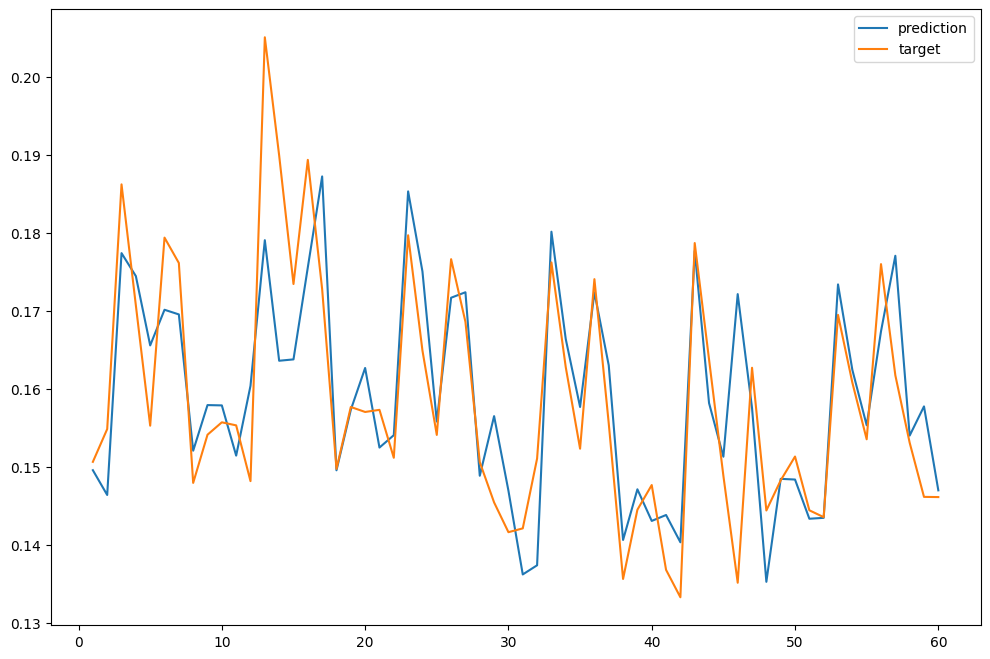

In [22]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [23]:
print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target).view(-1,1)).item()*100,'%')
print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target).view(-1,1)).item())
print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target).view(-1,1)).item()*100,'%')

SMAPE 3.697783872485161 %
RMSE 0.008356478996574879
MAPE 3.6952927708625793 %


In [ ]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,10081),pred_list,label='prediction')
axes.plot(np.arange(1,10081),target,label='target')
axes.legend()

In [ ]:
np.array(pred_list)

In [ ]:
target = data.iloc[-split:]
target = target.values.reshape(-1,1)
target

In [ ]:
print(FloatTensor(np.array(pred_list)).size(),FloatTensor(target).size())

In [ ]:
print('SMAPE',SMAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')
print('RMSE',RMSE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item())
print('MAPE',MAPE()(FloatTensor(np.array(pred_list).reshape(-1,1)),FloatTensor(target)).item()*100,'%')

In [ ]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-60:],label='prediction')
axes.plot(np.arange(1,61),target[-60:],label='target')
axes.legend()

In [ ]:
fig,axes = plt.subplots(1,1,figsize=(12,8))
axes.plot(np.arange(1,61),pred_list[-120:-60],label='prediction')
axes.plot(np.arange(1,61),target[-120:-60],label='target')
axes.legend()

In [ ]:
len(time_list)

In [ ]:
np.mean(time_list) 

In [ ]:
np.mean(time_list1) #pretraining 1Epoch 도는데 걸리는 시간